## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib

In [6]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit

# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constants
E = 19300e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
h = 7  # Isotropic hardening rate


def generate_strain_history(epsilon_0, a, num_strain_samples):
    # Parameters
    steps = np.linspace(0, num_strain_samples, num_strain_samples)  # Steps from 0 to 4000
    frequency = a / num_strain_samples  # Frequency for three cycles
    initial_amplitude = epsilon_0  # Initial amplitude
    amplitude_growth_rate = 0.00002  # Rate at which amplitude increases

    # Compute the amplitude as a function of steps
    amplitude_modulation = initial_amplitude + amplitude_growth_rate * steps

    # Generate the sine wave with varying amplitude
    strain = amplitude_modulation * np.sin(2 * np.pi * frequency * steps)
    
    return strain
    

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign


# Generate dataset
def generate_dataset(epsilon_0, a, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(epsilon_0, a, num_strain_samples)
    # Initialize state variables
    alpha, eps_p, delta_gamma = 0, 0, 0
    
    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

        # Store the data
        dataset.append([
            E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, delta_gamma
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [7]:
training = generate_dataset(epsilon_0=0.01, a=3, num_strain_samples=4000)

/home/uashfaq/anaconda3/envs/elasticityplasticity/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


In [8]:
columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cumulative_plastic_strain", "alpha", 'sign','plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [9]:
df[300:350]

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
300,1.930000e+10,150000000.0,7.0,611675.097340,0.015805,1.500000e+08,0.008033,0.008033,1.0,0.000032
301,1.930000e+10,150000000.0,7.0,605465.847136,0.015837,1.500000e+08,0.008065,0.008065,1.0,0.000031
302,1.930000e+10,150000000.0,7.0,599226.192611,0.015868,1.500000e+08,0.008096,0.008096,1.0,0.000031
303,1.930000e+10,150000000.0,7.0,592956.260149,0.015899,1.500000e+08,0.008127,0.008127,1.0,0.000031
304,1.930000e+10,150000000.0,7.0,586656.177187,0.015929,1.500000e+08,0.008157,0.008157,1.0,0.000030
305,1.930000e+10,150000000.0,7.0,580326.072205,0.015959,1.500000e+08,0.008187,0.008187,1.0,0.000030
306,1.930000e+10,150000000.0,7.0,573966.074730,0.015989,1.500000e+08,0.008217,0.008217,1.0,0.000030
307,1.930000e+10,150000000.0,7.0,567576.315329,0.016018,1.500000e+08,0.008246,0.008246,1.0,0.000029
308,1.930000e+10,150000000.0,7.0,561156.925610,0.016047,1.500000e+08,0.008275,0.008275,1.0,0.000029
309,1.930000e+10,150000000.0,7.0,554708.038217,0.016076,1.500000e+08,0.008304,0.008304,1.0,0.000029


In [10]:
save_dataset_to_csv(training)

Dataset saved to generated_dataset_von_mises_training_07_01_2025.csv


In [11]:
df=df.fillna(1)

In [12]:
df.isna().sum()

E                            0
sigma_y                      0
h                            0
yield_function               0
strain                       0
sigma_updated                0
cumulative_plastic_strain    0
alpha                        0
sign                         0
plastic_strain               0
dtype: int64

In [13]:
df.head(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
0,1.930000e+10,150000000.0,7.0,-1.500000e+08,0.000000,0.000000e+00,0.0,0.0,1.0,0.0
1,1.930000e+10,150000000.0,7.0,-1.490885e+08,0.000047,9.115350e+05,0.0,0.0,1.0,0.0
2,1.930000e+10,150000000.0,7.0,-1.481733e+08,0.000095,1.826690e+06,0.0,0.0,1.0,0.0
3,1.930000e+10,150000000.0,7.0,-1.472546e+08,0.000142,2.745443e+06,0.0,0.0,1.0,0.0
4,1.930000e+10,150000000.0,7.0,-1.463322e+08,0.000190,3.667775e+06,0.0,0.0,1.0,0.0
5,1.930000e+10,150000000.0,7.0,-1.454063e+08,0.000238,4.593665e+06,0.0,0.0,1.0,0.0
6,1.930000e+10,150000000.0,7.0,-1.444769e+08,0.000286,5.523091e+06,0.0,0.0,1.0,0.0
7,1.930000e+10,150000000.0,7.0,-1.435440e+08,0.000335,6.456033e+06,0.0,0.0,1.0,0.0
8,1.930000e+10,150000000.0,7.0,-1.426075e+08,0.000383,7.392469e+06,0.0,0.0,1.0,0.0
9,1.930000e+10,150000000.0,7.0,-1.416676e+08,0.000432,8.332378e+06,0.0,0.0,1.0,0.0


In [14]:
df.tail(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
3950,1.930000e+10,150000000.0,7.0,7.788697e+06,-2.037812e-02,1.500000e+08,-0.028150,0.481399,1.0,0.000404
3951,1.930000e+10,150000000.0,7.0,7.800978e+06,-1.997392e-02,1.500000e+08,-0.027746,0.481803,1.0,0.000404
3952,1.930000e+10,150000000.0,7.0,7.813090e+06,-1.956910e-02,1.500000e+08,-0.027341,0.482208,1.0,0.000405
3953,1.930000e+10,150000000.0,7.0,7.825032e+06,-1.916366e-02,1.500000e+08,-0.026936,0.482613,1.0,0.000405
3954,1.930000e+10,150000000.0,7.0,7.836804e+06,-1.875761e-02,1.500000e+08,-0.026530,0.483019,1.0,0.000406
3955,1.930000e+10,150000000.0,7.0,7.848405e+06,-1.835095e-02,1.500000e+08,-0.026123,0.483426,1.0,0.000407
3956,1.930000e+10,150000000.0,7.0,7.859836e+06,-1.794371e-02,1.500000e+08,-0.025716,0.483833,1.0,0.000407
3957,1.930000e+10,150000000.0,7.0,7.871096e+06,-1.753588e-02,1.500000e+08,-0.025308,0.484241,1.0,0.000408
3958,1.930000e+10,150000000.0,7.0,7.882184e+06,-1.712747e-02,1.500000e+08,-0.024899,0.484649,1.0,0.000408
3959,1.930000e+10,150000000.0,7.0,7.893100e+06,-1.671851e-02,1.500000e+08,-0.024491,0.485058,1.0,0.000409


In [16]:
strain_training= training[:,-6]

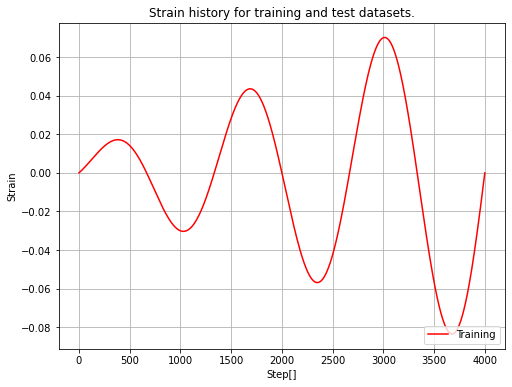

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

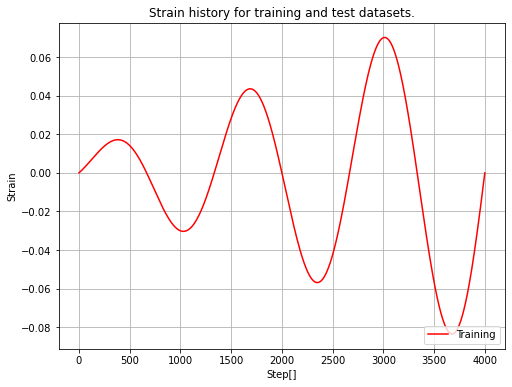

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

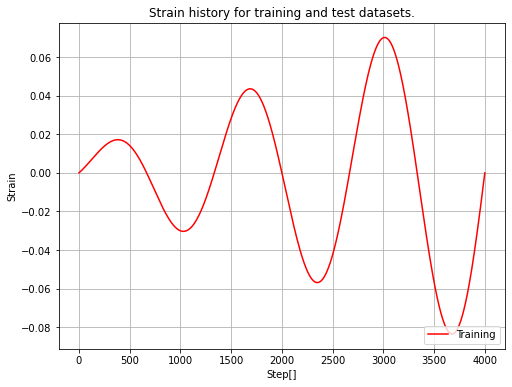

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

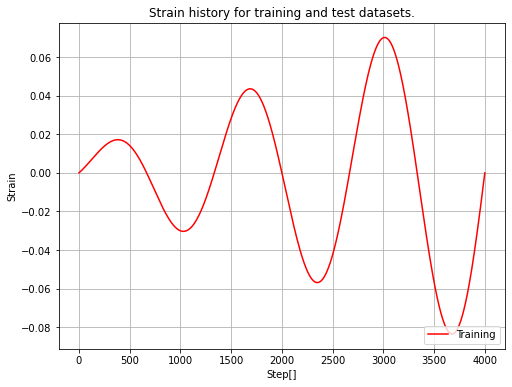

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [16]:
sign_training= training[:,-2]

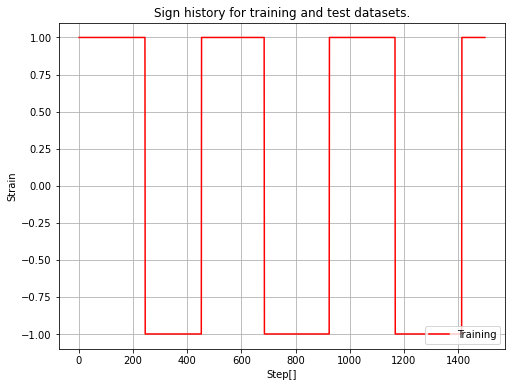

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(sign_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Sign history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [25]:
cm_plastic_strain_training= training[:,-4]

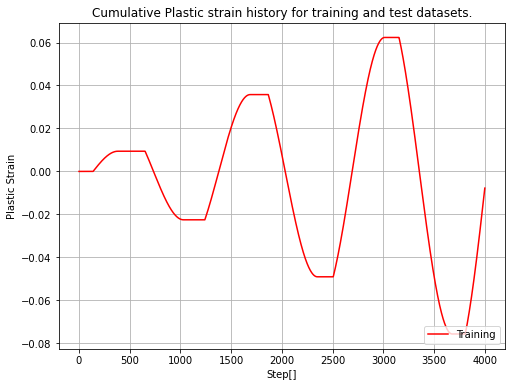

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(cm_plastic_strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Cumulative Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [28]:
plastic_strain_training= training[:,-1]

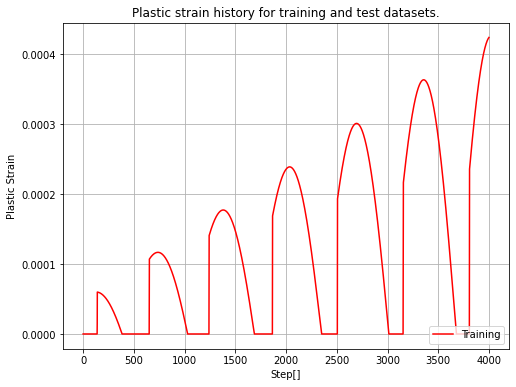

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [30]:
alpha_training= training[:,-3]
#alpha_test1= test1[:,-3]
#alpha_test2= test2[:,-3]

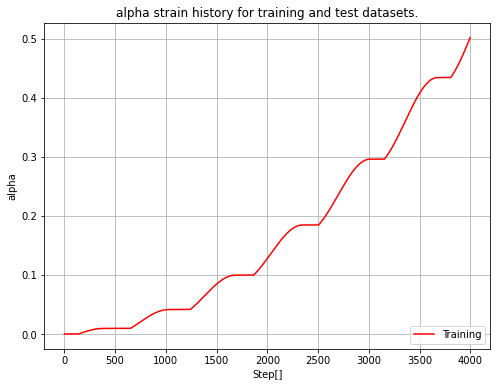

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(alpha_training, label='Training', color='red')
plt.xlabel('Step[]')
plt.ylabel('alpha')
plt.title('alpha strain history for training and test datasets.')

#y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
#plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [33]:
print(np.isnan(training).any())
print(np.isinf(training).any())

True
False


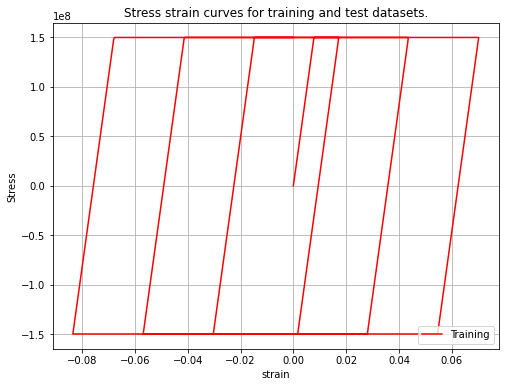

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

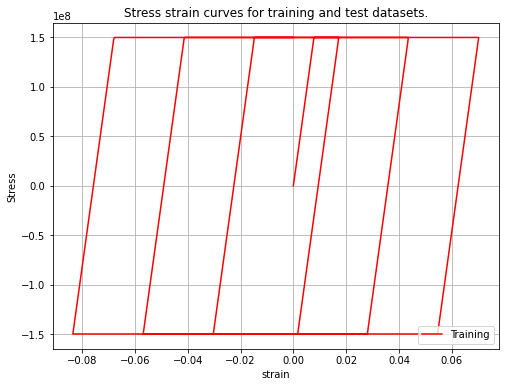

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

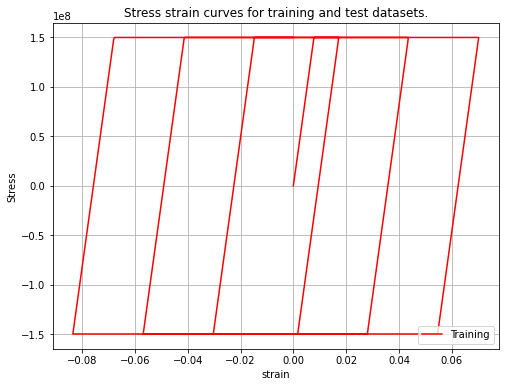

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

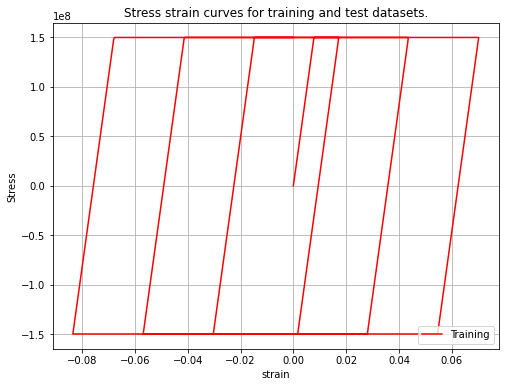

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,4], training[:,5], label='Training', color='red')
plt.xlabel('strain')
plt.ylabel('Stress')
plt.title('Stress strain curves for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()